#   Instalação e configuração do ambiente

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, PReLU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

In [2]:
!pip install gdown

In [3]:
!gdown https://drive.google.com/uc?id=1eCJz8mommzUbqhIvGm0GHx2AlR_Iw01V&authuser=0&export=download --folder

/bin/bash: --folder: command not found
Downloading...
From: https://drive.google.com/uc?id=1eCJz8mommzUbqhIvGm0GHx2AlR_Iw01V
To: /content/dataset.zip
100% 242M/242M [00:02<00:00, 118MB/s]


In [4]:
!ls

dataset.zip  sample_data


In [5]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/COVID/
  inflating: dataset/COVID/Covid (937).png  
  inflating: dataset/COVID/Covid (936).png  
  inflating: dataset/COVID/Covid (922).png  
  inflating: dataset/COVID/Covid (952).png  
  inflating: dataset/COVID/Covid (997).png  
  inflating: dataset/COVID/Covid (934).png  
  inflating: dataset/COVID/Covid (956).png  
  inflating: dataset/COVID/Covid (975).png  
  inflating: dataset/COVID/Covid (978).png  
  inflating: dataset/COVID/Covid (875).png  
  inflating: dataset/COVID/Covid (901).png  
  inflating: dataset/COVID/Covid (99).png  
  inflating: dataset/COVID/Covid (912).png  
  inflating: dataset/COVID/Covid (867).png  
  inflating: dataset/COVID/Covid (900).png  
  inflating: dataset/COVID/Covid (94).png  
  inflating: dataset/COVID/Covid (921).png  
  inflating: dataset/COVID/Covid (89).png  
  inflating: dataset/COVID/Covid (874).png  
  inflating: dataset/COVID/Covid (95).png  
  inflating: dataset/COVID/Covid

In [6]:
!ls
!rm -rf dataset.zip
!ls

dataset  dataset.zip  sample_data
dataset  sample_data


# Organização dos dados

In [7]:
covid_class = ['COVID', 'non-COVID']
data_dir = 'dataset/'
train_dir = os.path.join(data_dir)
IMAGE_SIZE = 64

# Funções

In [8]:
def create_data_frame():
    train_data = []
    for defects_id, sp in enumerate(covid_class):
        for file in os.listdir(os.path.join(train_dir, sp)):
            train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
    return pd.DataFrame(train_data, columns=[
        'file', 'id_class', 'class'])

In [9]:
def random_data_frame(data):
    data = data.sample(frac=1, random_state=42)
    data.index = np.arange(len(data))
    return data

In [10]:
def read_image(filepath):  # Loading a color image is the default flag
    return cv2.imread(os.path.join(data_dir, filepath))

In [11]:
def resize_image(image, image_size):  # Resize image to target size
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [12]:
def load_images(data):
    X_train = np.zeros((data.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
    for i, file in tqdm(enumerate(data['file'].values)):
        image = read_image(file)
        if image is not None:
            X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
    images = X_train / 255.  # Normalize the data
    print("Total de imagens carregadas: " + str(len(images)))
    return images

In [13]:
def image_data_gen():
    return ImageDataGenerator(
        rotation_range=20,  # Rotaciona aleatoriamente as imagens no intervalo de 0 a 20 graus
        width_shift_range=0.2,  # Desloca horizontalmente as imagens em até 10% do tamanho total
        height_shift_range=0.2,  # Desloca verticalmente as imagens em até 10% do tamanho total
        zoom_range=0.2,  # Aplica zoom aleatório nas imagens
        horizontal_flip=True,  # Realiza espelhamento horizontal aleatório nas imagens
        vertical_flip=True,
        fill_mode='nearest',  # Preenche pixels ausentes após transformações
    )

In [14]:
def create_model():
    densenet = DenseNet121(weights='imagenet', include_top=False)
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation=PReLU())(x)
    x = Dropout(0.3)(x)

    output = Dense(2, activation='softmax', name='root')(x)
    model = Model(input, output)
    optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999,
                     epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [15]:
def classification_summary(y_test, pred, pred_prob):
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred), 3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'), 3)*100))
    print("AUC score: {:.3f}".format(round(roc_auc_score(y_test, pred_prob), 3)*100))
    print('Recal Score = {}%'.format(round(recall_score(y_test, pred, average='weighted'), 3)*100))
    print('Precision = {}%'.format(round(precision_score(y_test, pred, average='weighted'), 3)*100))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))

# Visualização dos dados manipulados

In [16]:
data = create_data_frame()
print(data)

                                file  id_class      class
0              COVID/Covid (910).png         0      COVID
1              COVID/Covid (457).png         0      COVID
2              COVID/Covid (783).png         0      COVID
3                COVID/Covid (8).png         0      COVID
4              COVID/Covid (899).png         0      COVID
...                              ...       ...        ...
2476  non-COVID/Non-Covid (1020).png         1  non-COVID
2477     non-COVID/Non-Covid (8).png         1  non-COVID
2478   non-COVID/Non-Covid (920).png         1  non-COVID
2479   non-COVID/Non-Covid (724).png         1  non-COVID
2480    non-COVID/Non-Covid (79).png         1  non-COVID

[2481 rows x 3 columns]


In [17]:
data = random_data_frame(data)
print(data)

                               file  id_class      class
0             COVID/Covid (501).png         0      COVID
1             COVID/Covid (359).png         0      COVID
2     non-COVID/Non-Covid (285).png         1  non-COVID
3     non-COVID/Non-Covid (945).png         1  non-COVID
4            COVID/Covid (1033).png         0      COVID
...                             ...       ...        ...
2476  non-COVID/Non-Covid (381).png         1  non-COVID
2477          COVID/Covid (879).png         0      COVID
2478          COVID/Covid (192).png         0      COVID
2479  non-COVID/Non-Covid (463).png         1  non-COVID
2480          COVID/Covid (442).png         0      COVID

[2481 rows x 3 columns]


In [18]:
images = load_images(data)

2481it [00:26, 92.79it/s]


Total de imagens carregadas: 2481


In [19]:
categories = to_categorical(data['id_class'].values, num_classes=2)

In [20]:
data

,file,id_class,class
0,COVID/Covid (501).png,0,COVID
1,COVID/Covid (359).png,0,COVID
2,non-COVID/Non-Covid (285).png,1,non-COVID
3,non-COVID/Non-Covid (945).png,1,non-COVID
4,COVID/Covid (1033).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (381).png,1,non-COVID
2477,COVID/Covid (879).png,0,COVID
2478,COVID/Covid (192).png,0,COVID
2479,non-COVID/Non-Covid (463).png,1,non-COVID


# Criação dos modelos

In [21]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, categories, test_size=0.2)

In [22]:
datagen = image_data_gen()

In [23]:
datagen.fit(train_images)

In [24]:
model = create_model()

29084464/29084464 [==============================] - 0s 0us/step


In [25]:
model_checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

#  Usando o modelo Árvore de Decisão

In [26]:
# Achatamento das imagens para um vetor unidimensional
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [27]:
# Criar o modelo de árvore de decisão
model = DecisionTreeClassifier()
model.fit(train_images, train_labels)

DecisionTreeClassifier()

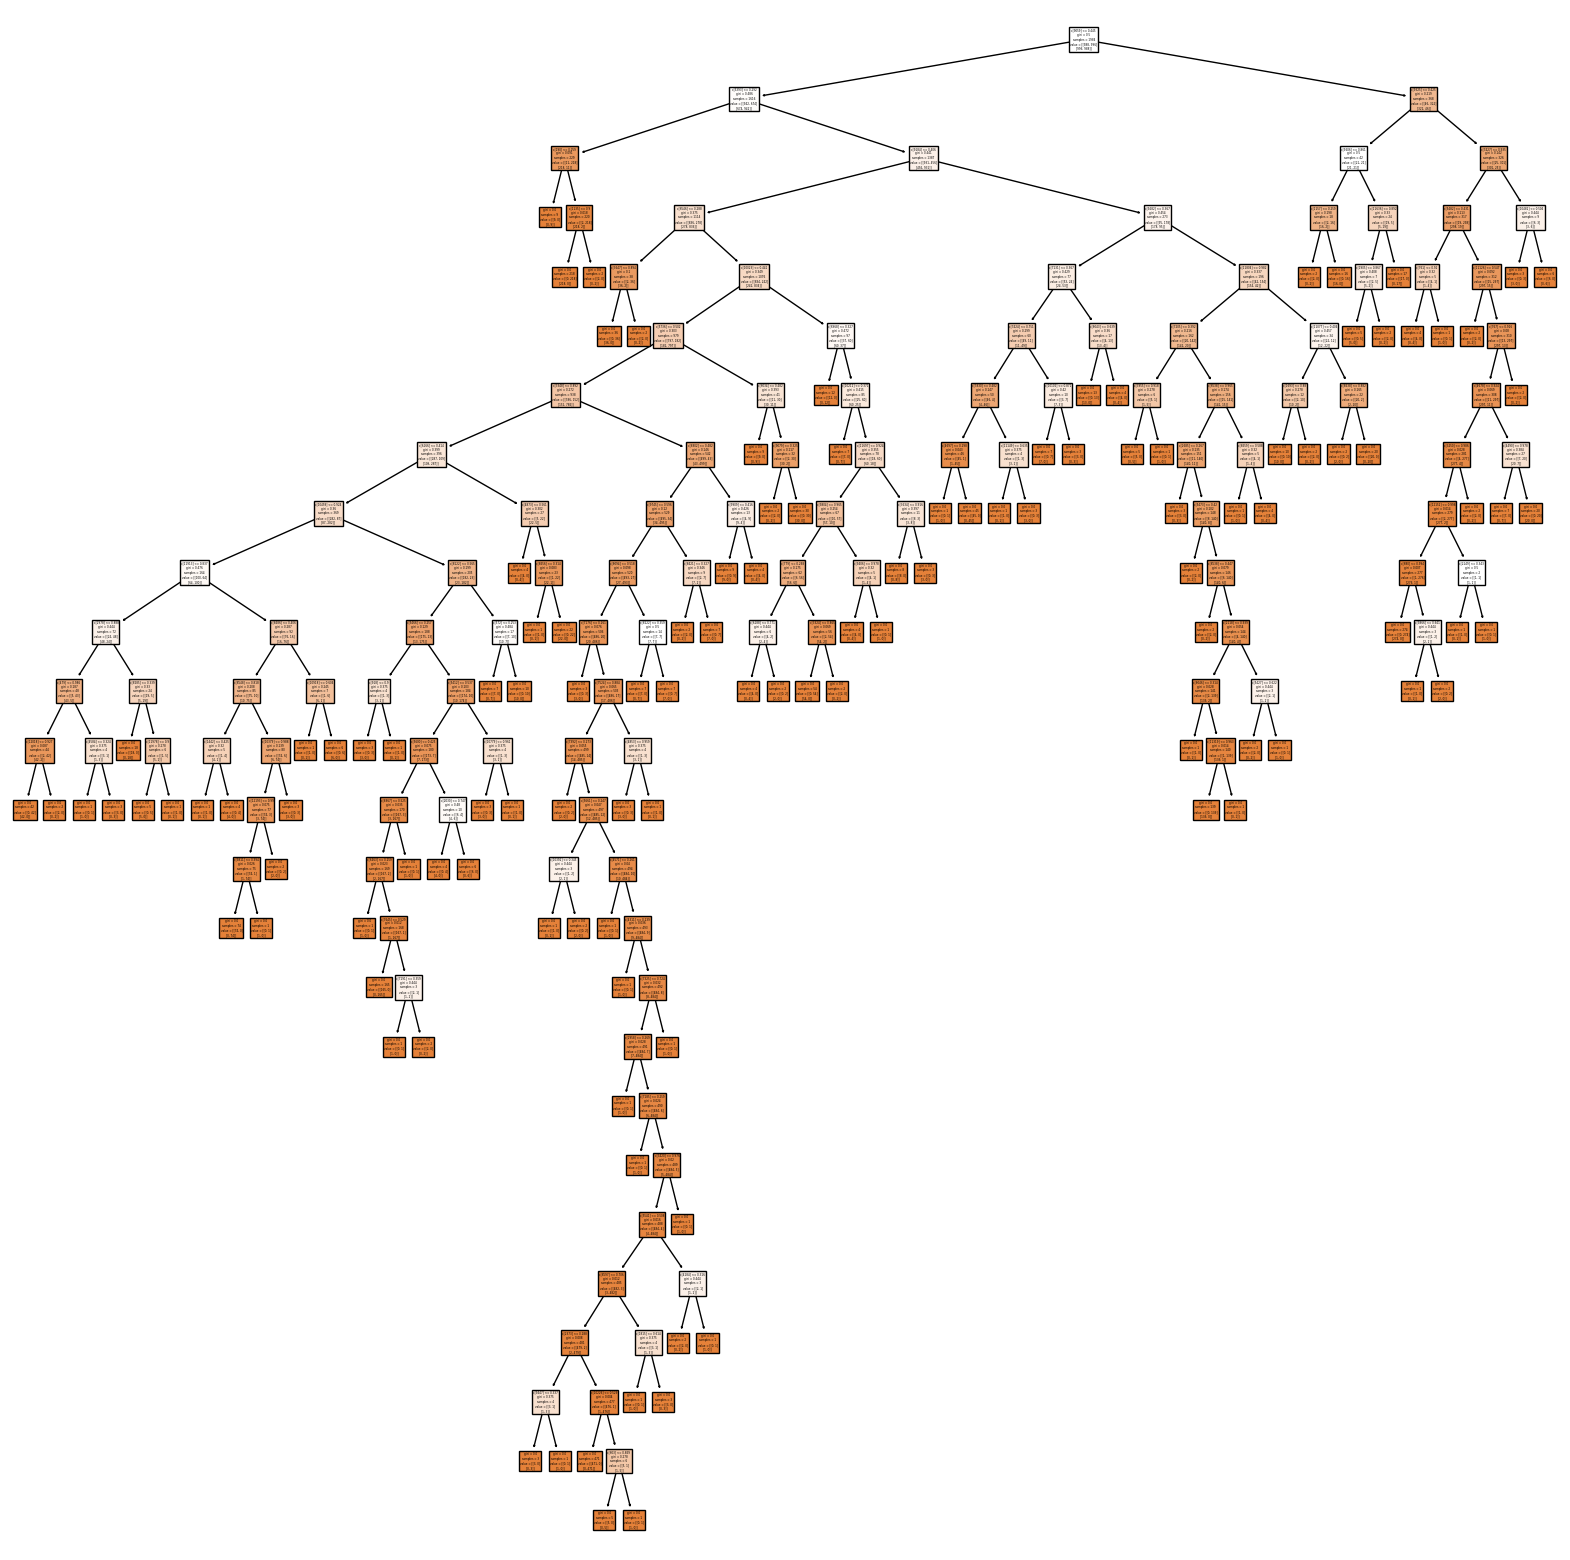

In [28]:
# Plotar a árvore de decisão
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(model, filled=True)
plt.show()

In [29]:
# Fazer previsões com o conjunto de teste
predictions = model.predict(test_images)

# Calcular as métricas das previsões
from sklearn.metrics import precision_score, recall_score

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')

print('Precision:', precision, '\nRecall:', recall, '\nAccuracy:', accuracy)

Precision: 0.8026823651519575 
Recall: 0.802515560165975 
Accuracy: 0.8028169014084507


In [30]:
classification_summary(test_labels, predictions.round().astype('int'), predictions)

Accuracy = 80.30000000000001%
F1 Score = 80.30000000000001%
AUC score: 80.300
Recal Score = 80.30000000000001%
Precision = 80.30000000000001%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       256
           1       0.80      0.79      0.80       241

   micro avg       0.80      0.80      0.80       497
   macro avg       0.80      0.80      0.80       497
weighted avg       0.80      0.80      0.80       497
 samples avg       0.80      0.80      0.80       497



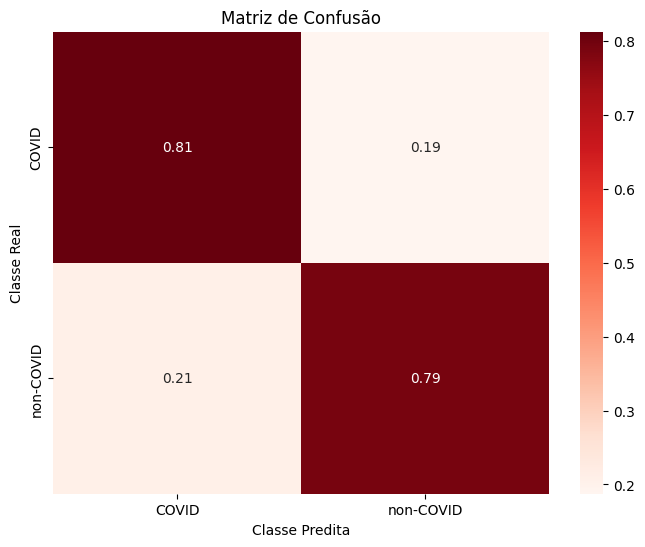

In [31]:
# matriz de confusao
rounded_labels = np.argmax(test_labels, axis=1)
predictions = model.predict(
    test_images).argmax(axis=1)
cm = confusion_matrix(rounded_labels, predictions)

# Normalizar a matriz de confusão
row_sums = cm.sum(axis=1)
normalized_confusion = cm / row_sums[:, np.newaxis]

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_confusion, annot=True, fmt=".2f", cmap='Reds',
            xticklabels=covid_class, yticklabels=covid_class)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()

#  Usando o modelo Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Achatamento das imagens para um vetor unidimensional
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [34]:
# Criar o modelo de árvore de decisão
#model = DecisionTreeClassifier()
model = RandomForestClassifier(n_estimators=100)
model.fit(train_images, train_labels)

RandomForestClassifier()

In [35]:
# Fazer previsões com o conjunto de teste
predictions = model.predict(test_images)

# Calcular as métricas das previsões
from sklearn.metrics import precision_score, recall_score, classification_report

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='macro')
recall = recall_score(test_labels, predictions, average='macro')

print('Precision:', precision, '\nRecall:', recall, '\nAccuracy:', accuracy)

Precision: 0.9235447154471546 
Recall: 0.9220046680497925 
Accuracy: 0.9215291750503019


In [36]:
classification_summary(test_labels, predictions.round().astype('int'), predictions)

Accuracy = 92.2%
F1 Score = 92.2%
AUC score: 92.300
Recal Score = 92.2%
Precision = 92.4%

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       256
           1       0.90      0.94      0.92       241

   micro avg       0.92      0.92      0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497
 samples avg       0.92      0.92      0.92       497



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


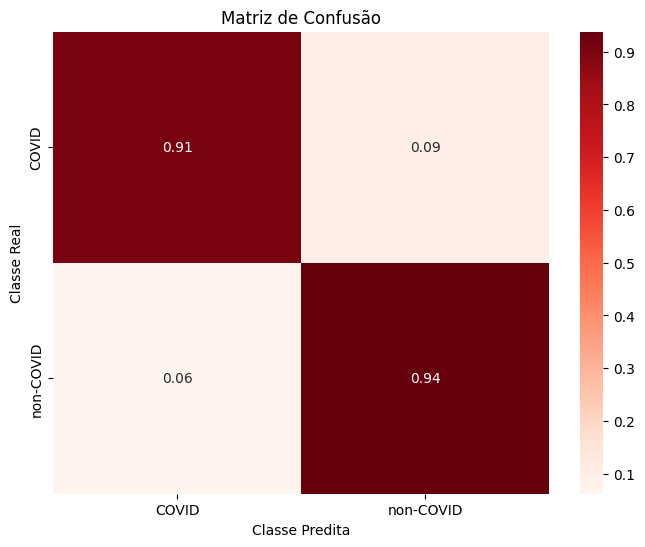

In [37]:
# matriz de confusao
rounded_labels = np.argmax(test_labels, axis=1)
predictions = model.predict(
    test_images).argmax(axis=1)
cm = confusion_matrix(rounded_labels, predictions)

# Normalizar a matriz de confusão
row_sums = cm.sum(axis=1)
normalized_confusion = cm / row_sums[:, np.newaxis]

# Plot da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_confusion, annot=True, fmt=".2f", cmap='Reds',
            xticklabels=covid_class, yticklabels=covid_class)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()